<a href="https://colab.research.google.com/github/kungfumas/aplikasi-deep-learning/blob/master/vehicle_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Persiapan

Ubah "Akselerator hardware" menggunakan "GPU" dengan menu "Edit" > "Setelan notebook" pada Google Colab


Impor dependensi

In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

Clone darknet dari repo AlexeyAB

In [7]:
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


Meng-compile darknet

In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

Mengunduh pre-trainned weight, data, config YOLOv4

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-06-09 01:44:09--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.24.102, 74.125.24.101, 74.125.24.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ats10naq01lk1s8hnn9kbkitomfq8qcc/1654739025000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2022-06-09 01:44:09--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ats10naq01lk1s8hnn9kbkitomfq8qcc/1654739025000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 142.251.12.132, 2404:6800:4003:c11::84
Connecting to doc-14-84-docs.googleusercontent.com (doc-14-84-doc

Konfigurasi YOLOv4 dengan pre-trainned

In [6]:
# mengabil semua functions dari darknet.py
from darknet import *
# load arsitektural network dari file pre-trainned YOLOv4
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# membuat function darknet helper untuk deteksi object
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # mengambil ukuran proporsional untuk membuat box
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # menjalankan darknet model untuk deteksi
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

# Tes pengenalan pada foto dari webcam

In [8]:
# membuat function JS ke image agar terbaca OpenCV
def js_to_image(js_reply):

  # decode gambar base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes ke numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array ke dalam gambar OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function convert gambar OpenCV bounding box ke dalam base64 byte string menjadi overlay di video stream
def bbox_to_bytes(bbox_array):

  # convert array ke gambar PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox ke png untuk return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [9]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Mengubah ukuran output dengan element video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Menunggu klik tombol Capture
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # mengambil data photo
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # memanggil function darknet helper
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop deteksi dan menggambar pada gambar webcam
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # simpan gambar
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


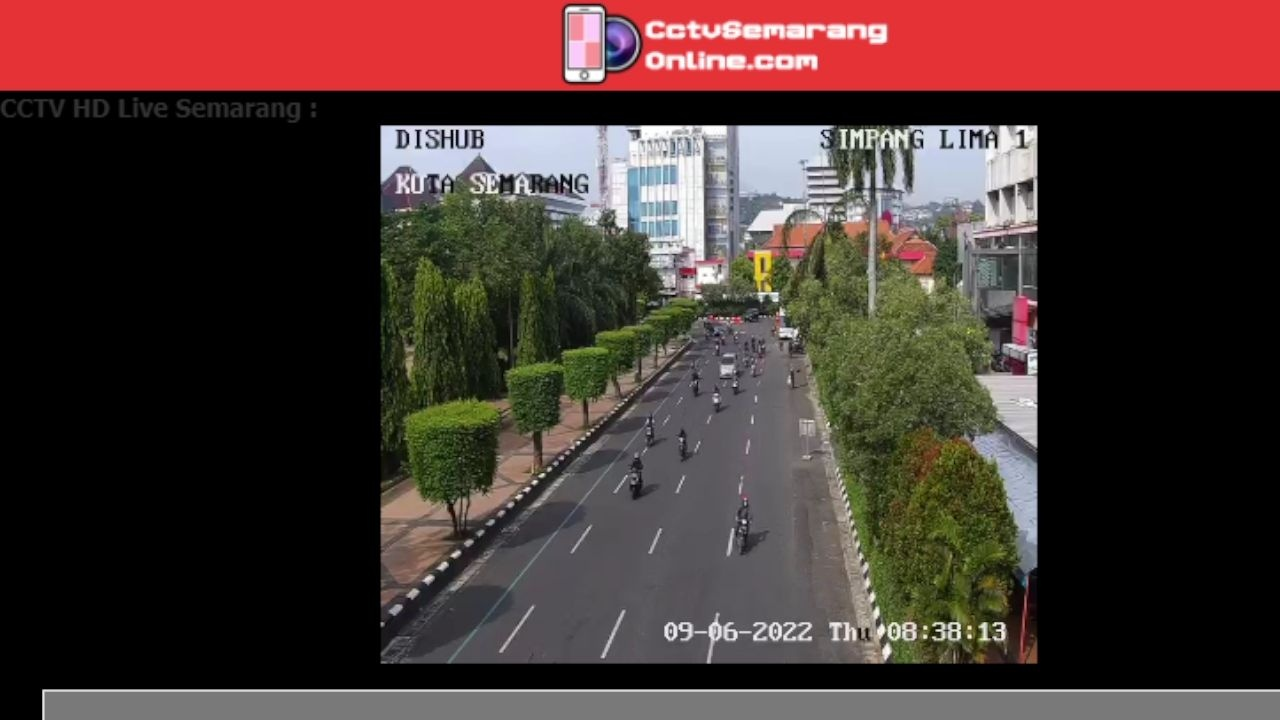

In [10]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Tampilkan hasil proses
  display(Image(filename))
except Exception as err:
  print(str(err))

# Tes pengenalan realtime pada video dari webcam

In [12]:
# JavaScript untuk membuat live video stream dari webcam
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Untuk selesai, klik disini atau di video untuk menghentikan demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [13]:
# mulai stream video dari webcam
video_stream()
# label video
label_html = 'Capturing...'
# inisialisasi bounding box
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS respon ke gambar OpenCV
    frame = js_to_image(js_reply["img"])

    # membuat overlay transparan untuk bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop deteksi dan menggambar dalam overlay transparan
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay dari bbox ke bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox ke frame selanjutnya untuk mendapat overlay baru
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Tes pengenalan video stream rtsp realtime dari ATCS POLDA, Semarang

Software diperlukan :
OBS Open Broadcaster Software - https://obsproject.com/download

Langkah :
1.  Buka OBS
2.  File > Settings > Video
3.  Ganti "Base Resolution" & "Canvas Resolution" menjadi 640x480
4.  Apply dan OK

1.  Tambahkan "Source", "Media Source"
2.  Uncheck "Local File"
3.  Input "rtsp://lalinsemarang.info:1935/live/polda.stream"
4.  Start Virtual Camera
5.  Minimize OBS, kembali ke chrome ini & jalankan

1.  **Ubah Camera Source pada Chrome ini menjadi "OBS Virtual Camera"**


In [14]:
# mulai stream video dari webcam
video_stream()
# label video
label_html = 'Capturing...'
# inisialisasi bounding box
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS respon ke gambar OpenCV
    frame = js_to_image(js_reply["img"])

    # membuat overlay transparan untuk bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop deteksi dan menggambar dalam overlay transparan
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay dari bbox ke bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox ke frame selanjutnya untuk mendapat overlay baru
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Screenshot output tes pengenalan object dengan video stream

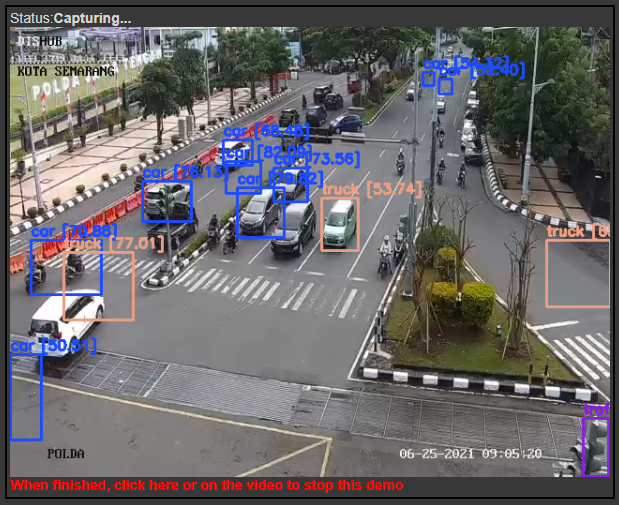

# Proses menghitung kendaraan motor video stream rstp dari ATCS POLDA, Semarang

In [19]:
# mulai stream video dari webcam
video_stream()
# label video
label_html = 'Capturing...'
# inisialisasi bounding box
bbox = ''
count = 0 
line = [(158, 283), (383, 322)]
car = 0
truck=0
bis =0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS respon ke gambar OpenCV
    frame = js_to_image(js_reply["img"])

    # membuat overlay transparan untuk bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop deteksi dan menggambar dalam overlay transparan
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
      if label == 'car':
        car = car + 1
      if label == 'truck':
        truck = truck + 1
      if label == 'bus':
        bis = bis + 1  
    bbox_array = cv2.line(bbox_array, line[0], line[1], (0, 255, 255), 2)
    bbox_array = cv2.putText(bbox_array, 'MOBIL: %d' %(car), (6,80), cv2.FONT_HERSHEY_DUPLEX, 0.45, (255, 255, 255), 1)
    bbox_array = cv2.putText(bbox_array, 'Truk: %d' %(truck), (6,100), cv2.FONT_HERSHEY_DUPLEX, 0.45, (255, 255, 255), 1)
    bbox_array = cv2.putText(bbox_array, 'Bis: %d' %(bis), (6,120), cv2.FONT_HERSHEY_DUPLEX, 0.45, (255, 255, 255), 1)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay dari bbox ke bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox ke frame selanjutnya untuk mendapat overlay baru
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Screenshot output akhir dan hasil penghitungan MOBIL di POLDA, Semarang


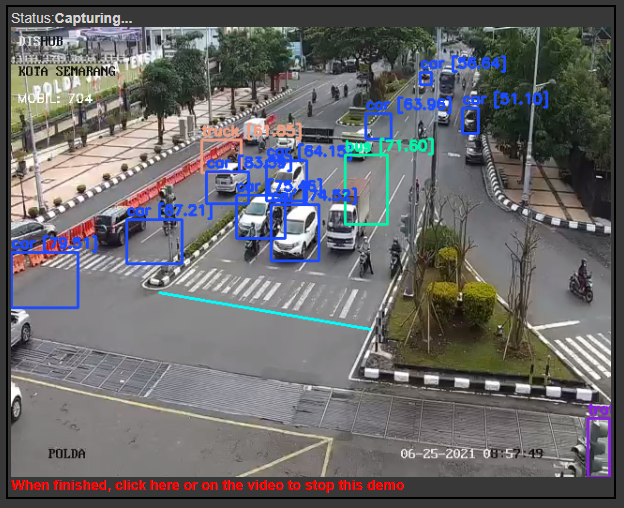